<a href="https://colab.research.google.com/github/PratikhyaManas/Detectron2_ObjectDetection/blob/master/InstanceSegmentation_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing the Dependencies**

In [0]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 22kB/s 
     |████████████████████████████████| 4.1MB 30.8MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=ad465e54dc88c712b77c8a461df1e5310feb786af71e50f63ff30b997081682a
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-b

In [0]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.2MB 741kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200506-cp36-none-any.whl size=40569 sha256=a78587ecc620eef6475b4a13d95714759d12105880bdd267dfa3804d2b1ad256
  Stored in directory: /root/.cache/pip/wheels/3f/db/ab/307827ba85b8cc1d288f096909499ecdbcac90db4edaa088fe
Successfully built fvcore


# **Importing the Libraries**

In [0]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# **Downloading the Dataset**

In [15]:
!wget https://github.com/PratikhyaManas/Detectron2_ObjectDetection/blob/master/CustomMicrocontrollerImages.zip

--2020-05-06 13:07:28--  https://github.com/PratikhyaManas/Detectron2_ObjectDetection/blob/master/CustomMicrocontrollerImages.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘CustomMicrocontrollerImages.zip.1’

CustomMicrocontroll     [  <=>               ]  66.28K   182KB/s    in 0.4s    

2020-05-06 13:07:30 (182 KB/s) - ‘CustomMicrocontrollerImages.zip.1’ saved [67866]



In [0]:
!unzip CustomMicrocontrollerImages.zip
!ls

In [17]:
!ls 'Microcontroller Segmentation'

labelme2coco.py  test  test.json  train  train.json


# **Register the Data**

In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_microcontroller_dicts(directory):
    classes = ['Raspberry_Pi_3', 'Arduino_Nano', 'ESP8266', 'Heltec_ESP32_Lora']
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 600
        record["width"] = 800
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "test"]:
    DatasetCatalog.register("microcontroller_" + d, lambda d=d: get_microcontroller_dicts('Microcontroller Segmentation/' + d))
    MetadataCatalog.get("microcontroller_" + d).set(thing_classes=['Raspberry_Pi_3', 'Arduino_Nano', 'ESP8266', 'Heltec_ESP32_Lora'])
microcontroller_metadata = MetadataCatalog.get("microcontroller_train")

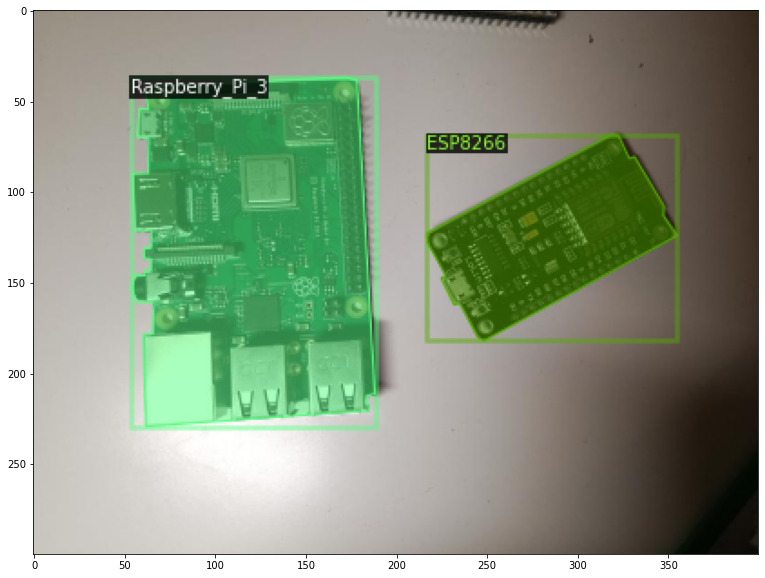

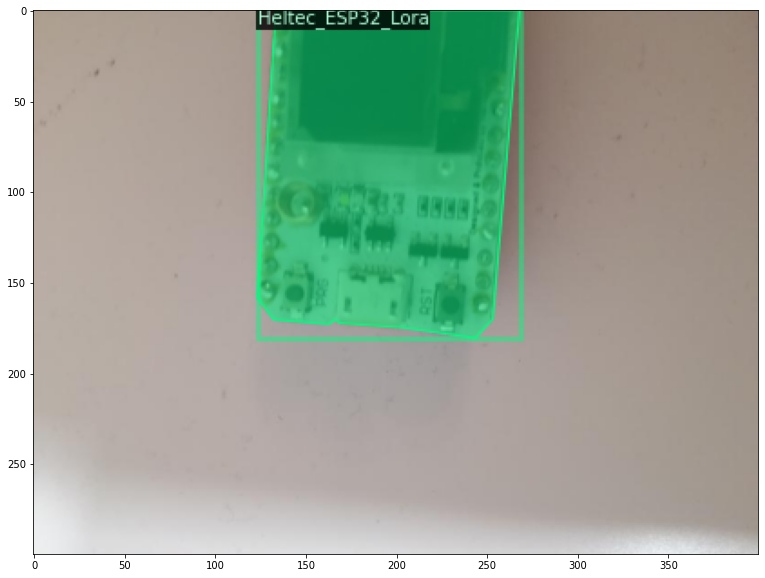

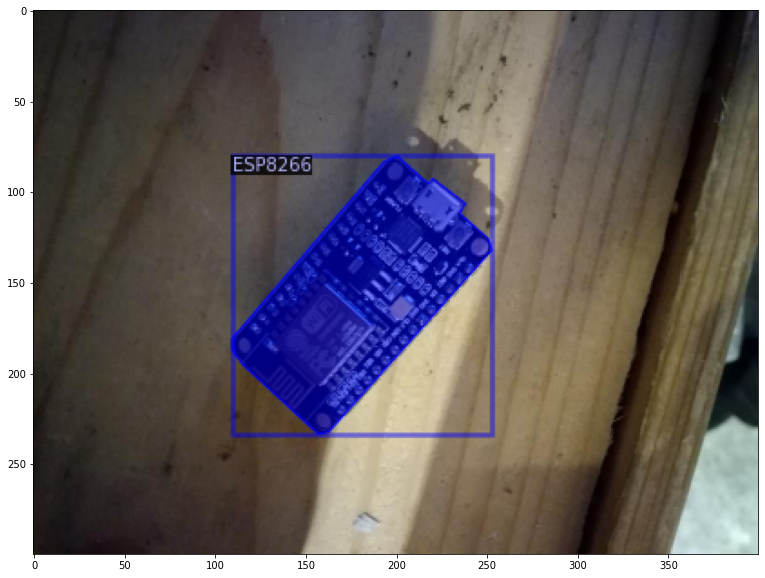

In [0]:
import random

dataset_dicts = get_microcontroller_dicts("Microcontroller Segmentation/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=microcontroller_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

# **Train the Model**

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("microcontroller_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/06 12:41:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:16, 11.0MB/s]                           


[05/06 12:42:02 d2.engine.train_loop]: Starting training from iteration 0
[05/06 12:42:08 d2.utils.events]:  eta: 0:04:43  iter: 19  total_loss: 2.646  loss_cls: 1.771  loss_box_reg: 0.162  loss_mask: 0.691  loss_rpn_cls: 0.006  loss_rpn_loc: 0.004  time: 0.2876  data_time: 0.0137  lr: 0.000005  max_mem: 2333M
[05/06 12:42:14 d2.utils.events]:  eta: 0:04:38  iter: 39  total_loss: 2.483  loss_cls: 1.617  loss_box_reg: 0.141  loss_mask: 0.687  loss_rpn_cls: 0.007  loss_rpn_loc: 0.003  time: 0.2854  data_time: 0.0044  lr: 0.000010  max_mem: 2333M
[05/06 12:42:20 d2.utils.events]:  eta: 0:04:31  iter: 59  total_loss: 2.084  loss_cls: 1.256  loss_box_reg: 0.137  loss_mask: 0.677  loss_rpn_cls: 0.008  loss_rpn_loc: 0.003  time: 0.2846  data_time: 0.0046  lr: 0.000015  max_mem: 2333M
[05/06 12:42:26 d2.utils.events]:  eta: 0:04:25  iter: 79  total_loss: 1.691  loss_cls: 0.879  loss_box_reg: 0.131  loss_mask: 0.666  loss_rpn_cls: 0.005  loss_rpn_loc: 0.003  time: 0.2847  data_time: 0.0042  lr:

# **Inference Model**

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("microcontroller_test", )
predictor = DefaultPredictor(cfg)

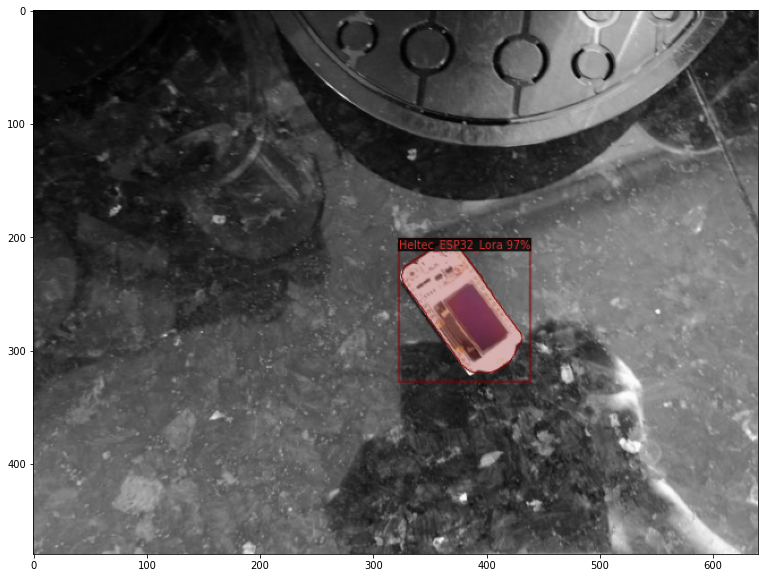

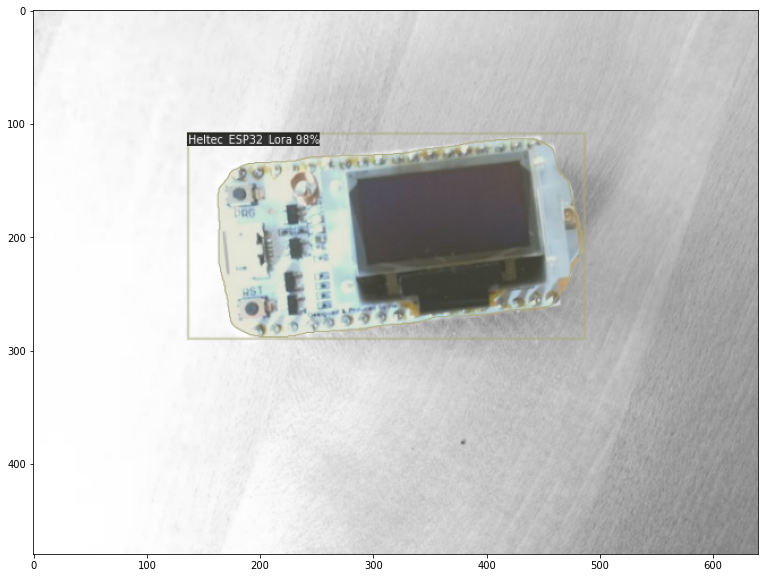

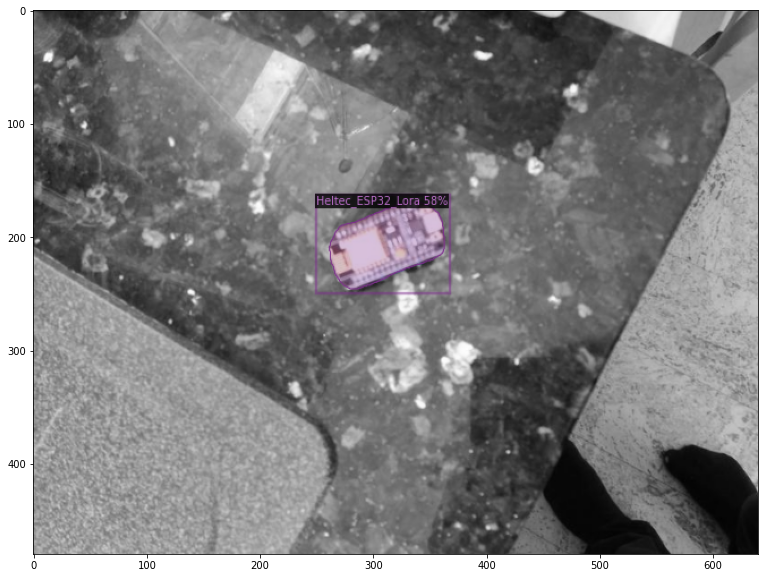

In [0]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_microcontroller_dicts('Microcontroller Segmentation/test')
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()